## Customer Segmentation for E-commerce Business

*****

In e-commerce, customer segmentation is essential for tailoring marketing strategies, enhancing customer satisfaction, and boosting revenue. By dividing customers into distinct groups based on their behaviors, preferences, and demographics, businesses can better understand and serve their audience.

This project focuses on implementing customer segmentation using clustering algorithms on an e-commerce dataset. We’ll start by exploring and preprocessing the data, then engineer relevant features. Next, we’ll apply clustering techniques, evaluate the models, and visualize the results to derive actionable business insights.

We’ll be running this Big Data project on Amazon EMR using PySpark, with our data stored in AWS S3.

In [1]:
# src/data_preprocessing.py
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, mean, max, datediff, current_date
from pyspark.sql.types import DateType
import warnings
import os

# Set environment variable to disable monitoring widget
os.environ['DISABLE_AWS_EDITOR_SPARK_MONITORING_WIDGET'] = 'true'

# Initialize Spark session
spark = SparkSession.builder \
    .appName("CustomerSegmentation") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .getOrCreate()

# Ignore warnings
warnings.filterwarnings('ignore')

# Set logging level to DEBUG
spark.sparkContext.setLogLevel("DEBUG")

print("Spark Session Initialized.")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1730312412193_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Spark Session Initialized.

### 1. Data Loading and Preprocessing

Loading Data from S3

In [2]:
behavioral_df = spark.read.parquet('s3://meet-big-data-bucket/behavioral.parquet')
transactions_df = spark.read.parquet('s3://meet-big-data-bucket/transactions.parquet')
engagement_df = spark.read.parquet('s3://meet-big-data-bucket/engagement.parquet')
demographics_df = spark.read.parquet('s3://meet-big-data-bucket/demographics.parquet')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
behavioral_df.show(5)
behavioral_df.printSchema()
demographics_df.show(5)
demographics_df.printSchema()
engagement_df.show(5)
engagement_df.printSchema()
transactions_df.show(5)
transactions_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-------------------+-----------+---------------+----------+
|           SessionID|          CustomerID|        SessionDate|PagesViewed|SessionDuration|DeviceType|
+--------------------+--------------------+-------------------+-----------+---------------+----------+
|e423b82b-7707-432...|b74fcf86-ca7b-4da...|2024-03-19 13:48:59|          1|          23.62|   Desktop|
|432f9f7f-e567-4f3...|1f0d519b-b979-415...|2024-07-09 01:52:53|          1|          51.11|   Desktop|
|46deb9d4-971b-4f6...|155ed1a7-fd70-407...|2023-12-08 11:56:55|         29|            1.0|    Mobile|
|43588c68-6ba0-425...|8d4212a8-cb66-45c...|2024-03-17 09:05:31|         55|          35.24|   Desktop|
|0daf9055-b142-41d...|199abfca-1af5-442...|2024-05-12 03:14:18|          2|            1.0|    Tablet|
+--------------------+--------------------+-------------------+-----------+---------------+----------+
only showing top 5 rows

root
 |-- SessionID: string (nullable = true)
 |

Convert Date Columns to Date type

In [4]:
behavioral_df = behavioral_df.withColumn("SessionDate", col("SessionDate").cast(DateType()))
transactions_df = transactions_df.withColumn("TransactionDate", col("TransactionDate").cast(DateType()))
engagement_df = engagement_df.withColumn("CampaignDate", col("CampaignDate").cast(DateType()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Aggregating Dataframes

In [5]:
# Aggregate Transaction Data
aggregated_transactions = transactions_df.groupBy("CustomerID").agg(
count("TransactionID").alias("total_transactions"),
sum("PurchaseAmount").alias("total_spent"),
mean("PurchaseAmount").alias("avg_transaction_value"),
max("TransactionDate").alias("last_purchase_date")
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# Aggregate Engagement Data
aggregated_engagement = engagement_df.groupBy("CustomerID").agg(
sum("EmailsOpened").alias("total_emails_opened"),
sum("Clicks").alias("total_clicks"),
max("PointsAccumulated").alias("total_points_accumulated")
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Aggregate Engagement Data
aggregated_engagement = engagement_df.groupBy("CustomerID").agg(
sum("EmailsOpened").alias("total_emails_opened"),
sum("Clicks").alias("total_clicks"),
max("PointsAccumulated").alias("total_points_accumulated")
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Aggregate Behavioral Data
aggregated_behavioral = behavioral_df.groupBy("CustomerID").agg(
sum("PagesViewed").alias("total_pages_viewed"),
mean("SessionDuration").alias("avg_session_duration"),
count("SessionID").alias("total_sessions")
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Merge all aggregated DataFrames with demographics

In [9]:
combined_df = demographics_df.join(aggregated_transactions, "CustomerID", "left") \
.join(aggregated_engagement, "CustomerID", "left") \
.join(aggregated_behavioral, "CustomerID", "left")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Handle missing values

In [10]:
combined_df = combined_df.fillna({"LoyaltyStatus": "Basic"})

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# Display the combined DataFrame
combined_df.show(5)
combined_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---+------+--------+-----------+--------+--------------+-------------+------------------+------------------+---------------------+------------------+-------------------+------------+------------------------+------------------+--------------------+--------------+
|          CustomerID|Age|Gender|Location|  Education|  Income|MarriageStatus|LoyaltyStatus|total_transactions|       total_spent|avg_transaction_value|last_purchase_date|total_emails_opened|total_clicks|total_points_accumulated|total_pages_viewed|avg_session_duration|total_sessions|
+--------------------+---+------+--------+-----------+--------+--------------+-------------+------------------+------------------+---------------------+------------------+-------------------+------------+------------------------+------------------+--------------------+--------------+
|f788f889-763c-4be...| 33|  Male| Chicago|   Bachelor| 28431.5|        Single|        Basic|                20| 2577.580416607786|    128.8790208

### 2. EDA Analysis

#### 2.1 Age Distribution

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

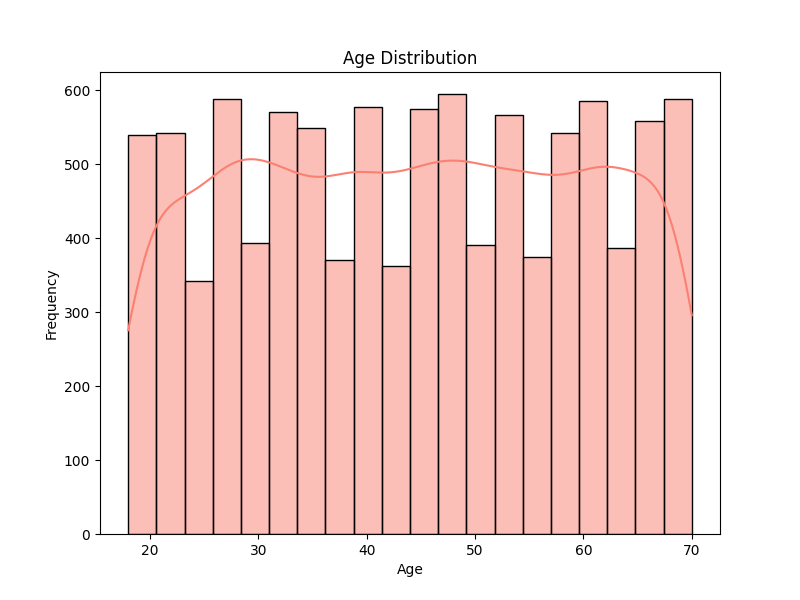

In [12]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

# Select the relevant columns for EDA
eda_df = combined_df.select("Age", "Income")

# Convert to Pandas DataFrame for visualization
eda_pd = eda_df.toPandas()

# Distribution of Age
plt.figure(figsize=(8, 6))
sns.histplot(eda_pd['Age'], bins=20, kde=True, color='salmon')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
%matplot plt


#### 2.2 Income Distribution

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

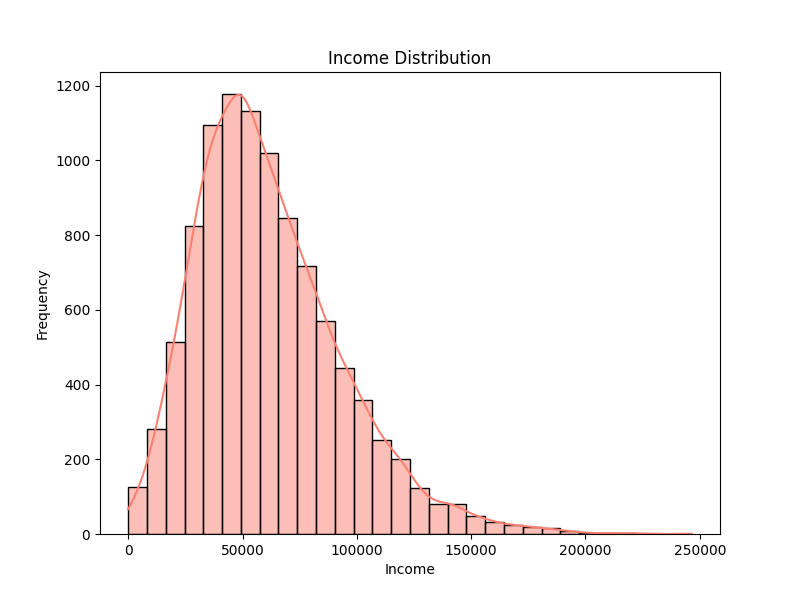

In [13]:
# Distribution of Income
plt.figure(figsize=(8, 6))
sns.histplot(eda_pd['Income'], bins=30, kde=True, color='salmon')
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
%matplot plt

#### 2.3 Loyalty Status Distribution

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

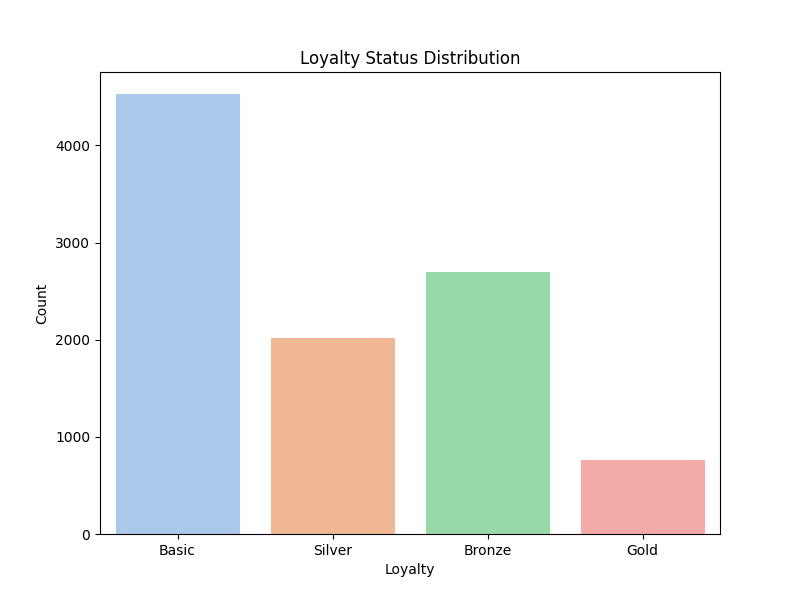

In [14]:
# Convert to Pandas DataFrame for visualization
combined_pd = combined_df.toPandas()

# Bar plot for Gender distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=combined_pd, x='LoyaltyStatus', palette='pastel')
plt.title('Loyalty Status Distribution')
plt.xlabel('Loyalty')
plt.ylabel('Count')
%matplot plt

### 3. Feature Enginerring

#### 3.1 Categorical Encoding

In [15]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Ordinal Encoding

In [16]:
# Define ordinal mappings for 'LoyaltyStatus' and 'Education'
loyalty_mapping = {'Basic': 0, 'Bronze': 1, 'Silver': 2, 'Gold': 3}
education_mapping = {'Other': 0, 'High School': 1, 'Bachelor': 2, 'Master': 3, 'PhD': 4}
loyalty_udf = udf(lambda x: loyalty_mapping.get(x, 0), IntegerType())
education_udf = udf(lambda x: education_mapping.get(x, 0), IntegerType())


# Apply ordinal encoding
scaled_df = combined_df.withColumn(
"LoyaltyProgramStatus_encoded", loyalty_udf(col("LoyaltyStatus"))
).withColumn(
"Education_encoded", education_udf(col("Education"))
)

# Drop original ordinal columns
scaled_df = scaled_df.drop("LoyaltyStatus", "Education")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

One-Hot Encoding

In [17]:
# Define categorical columns for One-Hot Encoding
categorical_cols = ['Gender', 'MarriageStatus', 'Location']

# Initialize StringIndexer for each categorical column
indexers = [
    StringIndexer(inputCol=column, outputCol=column + "Index", handleInvalid="keep")
    for column in categorical_cols
]


# Initialize OneHotEncoder for each indexed categorical column
encoders = [
    OneHotEncoder(inputCols=[column + "Index"], outputCols=[column + "_OHE"])
    for column in categorical_cols
]


# Create a Pipeline for indexing and encoding
pipeline = Pipeline(stages=indexers + encoders)
pipeline_model = pipeline.fit(scaled_df)
scaled_df = pipeline_model.transform(scaled_df)

# Drop the original categorical columns
scaled_df = scaled_df.drop(*categorical_cols)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 3.2 Feature Enginerring

Recency

In [18]:
# Calculate recency
scaled_df = scaled_df.withColumn(
"recency", datediff(current_date(), col("last_purchase_date"))
)

# Drop Last Purchase Date
scaled_df = scaled_df.drop("last_purchase_date")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Engagement Score

In [19]:
# Create engagement score
scaled_df = scaled_df.withColumn(
"engagement_score",
col("total_emails_opened") * 0.5 + col("total_clicks") * 0.5 )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Behavioral Score

In [20]:
# Create behavioral score
scaled_df = scaled_df.withColumn(
"behavioral_score",
col("total_pages_viewed") * 0.4 + col("avg_session_duration") * 0.3 + col("total_sessions") * 0.3
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Spend - Engagement Interaction

In [21]:
# Create interaction feature between 'scaled_total_spent' and 'scaled_engagement_score'
scaled_df = scaled_df.withColumn(
"spend_engagement_interaction",
col("total_spent") * col("engagement_score")
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Lifetime Vlaue - LTV

In [22]:
scaled_df = scaled_df.withColumn(
"LTV",
col("avg_transaction_value") * col("total_transactions")
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
scaled_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- CustomerID: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Income: double (nullable = true)
 |-- total_transactions: long (nullable = true)
 |-- total_spent: double (nullable = true)
 |-- avg_transaction_value: double (nullable = true)
 |-- total_emails_opened: long (nullable = true)
 |-- total_clicks: long (nullable = true)
 |-- total_points_accumulated: long (nullable = true)
 |-- total_pages_viewed: long (nullable = true)
 |-- avg_session_duration: double (nullable = true)
 |-- total_sessions: long (nullable = true)
 |-- LoyaltyProgramStatus_encoded: integer (nullable = true)
 |-- Education_encoded: integer (nullable = true)
 |-- GenderIndex: double (nullable = false)
 |-- MarriageStatusIndex: double (nullable = false)
 |-- LocationIndex: double (nullable = false)
 |-- Gender_OHE: vector (nullable = true)
 |-- MarriageStatus_OHE: vector (nullable = true)
 |-- Location_OHE: vector (nullable = true)
 |-- recency: integer (nullable = true)
 |-- engagement_scor

### 3.3 Feature Scaling

In [24]:
# Get all numeric columns
numeric_cols = [col_name for col_name, dtype in scaled_df.dtypes if dtype in ('int', 'bigint', 'double', 'float', 'long', 'short')]
numeric_cols 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['Age', 'Income', 'total_transactions', 'total_spent', 'avg_transaction_value', 'total_emails_opened', 'total_clicks', 'total_points_accumulated', 'total_pages_viewed', 'avg_session_duration', 'total_sessions', 'LoyaltyProgramStatus_encoded', 'Education_encoded', 'GenderIndex', 'MarriageStatusIndex', 'LocationIndex', 'recency', 'engagement_score', 'behavioral_score', 'spend_engagement_interaction', 'LTV']

In [25]:
# Assemble numeric features into a single vector
assembler = VectorAssembler(
inputCols=numeric_cols,
outputCol="numeric_features"
)

# Initialize the StandardScaler
scaler = StandardScaler(
inputCol="numeric_features",
outputCol="scaled_features",
withStd=True,
withMean=True
)

# Create a Pipeline for assembling and scaling
scaling_pipeline = Pipeline(stages=[assembler, scaler])
scaling_model = scaling_pipeline.fit(scaled_df)
scaled_df = scaling_model.transform(scaled_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# Convert the 'scaled_features' vector to an array for individual column access
from pyspark.ml.functions import vector_to_array
scaled_df = scaled_df.withColumn("scaled_features_array", vector_to_array("scaled_features"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# Replace original numeric columns with scaled columns prefixed with 'scaled_'
for i, col_name in enumerate(numeric_cols):
    scaled_col = f"scaled_{col_name}"
    scaled_df = scaled_df.withColumn(scaled_col, col("scaled_features_array")[i])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
# Drop the original numeric columns and intermediate columns
scaled_df = scaled_df.drop("numeric_features", "scaled_features", "scaled_features_array") \
.drop(*numeric_cols)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
# Display the scaled DataFrame
scaled_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+------------------+-------------+--------------------+--------------------+-------------------------+-------------------+----------------------------+--------------------------+--------------------+-------------------------------+-------------------------+---------------------------+---------------------+-----------------------------------+------------------------+--------------------+--------------------------+--------------------+-------------------+-----------------------+-----------------------+-----------------------------------+-------------------+
|          CustomerID|   Gender_OHE|MarriageStatus_OHE| Location_OHE|          scaled_Age|       scaled_Income|scaled_total_transactions| scaled_total_spent|scaled_avg_transaction_value|scaled_total_emails_opened| scaled_total_clicks|scaled_total_points_accumulated|scaled_total_pages_viewed|scaled_avg_session_duration|scaled_total_sessions|scaled_LoyaltyProgramStatus_encoded|scaled_Education_encoded|

### 4. Feature Selection

In [30]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Unpacking OHE Vector into individual columns**

In [31]:
from pyspark.ml.functions import vector_to_array

# Turn those one-hot encoded vectors into arrays
# Why? Because right now they're all packed into one column as vectors, and we want to break them out into separate pieces.
scaled_df = scaled_df.withColumn("Gender_OHE_array", vector_to_array("Gender_OHE")) \
                     .withColumn("MarriageStatus_OHE_array", vector_to_array("MarriageStatus_OHE")) \
                     .withColumn("Location_OHE_array", vector_to_array("Location_OHE"))

# Figure out how many categories each one-hot column has
# Basically, we're counting how many different pieces are in each of those arrays.
num_gender_categories = len(scaled_df.select("Gender_OHE_array").first()[0])
num_marriage_status_categories = len(scaled_df.select("MarriageStatus_OHE_array").first()[0])
num_location_categories = len(scaled_df.select("Location_OHE_array").first()[0])

# Make separate columns for each category
# We're taking each piece from those arrays and giving it its own column. This way, each category is its own thing.
for i in range(num_gender_categories):
    scaled_df = scaled_df.withColumn(f"Gender_OHE_{i}", col("Gender_OHE_array")[i])

for i in range(num_marriage_status_categories):
    scaled_df = scaled_df.withColumn(f"MarriageStatus_OHE_{i}", col("MarriageStatus_OHE_array")[i])

for i in range(num_location_categories):
    scaled_df = scaled_df.withColumn(f"Location_OHE_{i}", col("Location_OHE_array")[i])

# Get rid of the original vector columns
# Now that we've split them up, we don't need the original packed columns anymore. Let's clean up!
scaled_df = scaled_df.drop("Gender_OHE", "MarriageStatus_OHE", "Location_OHE",
                           "Gender_OHE_array", "MarriageStatus_OHE_array", "Location_OHE_array")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**Creating vector_df**

In [32]:
# Defining input_cols with all numeric columns including the columns from OHE
input_cols = [col_name for col_name in scaled_df.columns if col_name.startswith("scaled_") or col_name.endswith("_OHE")]

# Assemble features into vector
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
vector_df = assembler.transform(scaled_df.select(*input_cols)).select("features")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 4.1 K Means Segementationusing High Correlated Features

In [33]:

# Compute Correlation Matrix
corr_matrix = Correlation.corr(vector_df, "features").head()[0].toArray()

# Convert to Pandas DataFrame for easier handling
correlation_matrix = pd.DataFrame(corr_matrix, index=input_cols, columns=input_cols)

# Select features with correlation > 0.5 with 'scaled_total_spent'
high_correlation_threshold = 0.5
target_feature = 'scaled_total_spent'

high_corr_features = correlation_matrix[target_feature].abs() > high_correlation_threshold
selected_features = correlation_matrix.columns[high_corr_features].tolist()
print("Selected features based on correlation:", selected_features)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Selected features based on correlation: ['scaled_total_spent', 'scaled_avg_transaction_value', 'scaled_total_emails_opened', 'scaled_total_clicks', 'scaled_total_points_accumulated', 'scaled_total_pages_viewed', 'scaled_avg_session_duration', 'scaled_LoyaltyProgramStatus_encoded', 'scaled_engagement_score', 'scaled_behavioral_score', 'scaled_spend_engagement_interaction', 'scaled_LTV']

- To reduce multicollinearity, we need to select features that are highly correlated with our target but not with each other. 

- In the above output, we have got the highly correlated features with our target, but also, some of them are internally correlated.

Here is the interrelated features:

- **'scaled_engagement_score'** is calculated from 'scaled_total_emails_opened', and 'scaled_total_clicks',

- **'scaled_behavioral_score'** is calculated from 'scaled_total_pages_viewed', and 'scaled_avg_session_duration',

- **'scaled_spend_engagement_interaction'**, is calculated from 'scaled_total_spent', and  'scaled_engagement_score',

Therefore, the following features are selected to reduce multicollinearity:

    - 'scaled_total_spent', 
    - 'scaled_avg_transaction_value', 
    - 'scaled_total_points_accumulated', 
    - 'scaled_LoyaltyProgramStatus_encoded', 
    - 'scaled_engagement_score', 
    - 'scaled_behavioral_score', 
    - 'scaled_LTV'


In [34]:
selected_features = ['scaled_total_spent',
'scaled_avg_transaction_value',
'scaled_total_points_accumulated',
'scaled_LoyaltyProgramStatus_encoded',
'scaled_engagement_score',
'scaled_behavioral_score',
'scaled_LTV']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model Implementation

In [35]:
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
assembler = VectorAssembler(inputCols=selected_features, outputCol="model_features")
model_df = assembler.transform(scaled_df).select("CustomerID", "model_features")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
k = 2 # Number of clusters
kmeans = KMeans(featuresCol="model_features", k=k, seed=1)
kmeans_model = kmeans.fit(model_df)
kmeans_predictions = kmeans_model.transform(model_df)

# Evaluate K-Means
evaluator = ClusteringEvaluator(featuresCol="model_features")
silhouette_kmeans = evaluator.evaluate(kmeans_predictions)
print(f"K-Means Silhouette Score: {silhouette_kmeans}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

K-Means Silhouette Score: 0.7270781773018489

**Silhouette Score**

- The Silhouette Score evaluates clustering quality by measuring how similar an object is to its own cluster versus others. 

- It ranges from -1 to 1; a score near 1 indicates good clustering, while 0 means points are near cluster boundaries, and negative values suggest misassignment. 

- A score above 0.5 is generally acceptable.

#### 4.2 KMeans Clustering using PCA

In [38]:
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

# Step 1: Prepare Data for PCA
input_cols = [col_name for col_name in scaled_df.columns if col_name.startswith("scaled_") or col_name.endswith("_OHE")]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
vector_df = assembler.transform(scaled_df)

# Step 2: Fit PCA with all components
pca_full = PCA(k=len(input_cols), inputCol="features", outputCol="pca_features_full")
pca_full_model = pca_full.fit(vector_df)

# Calculate the number of components needed to retain 95% variance
explained_variance = pca_full_model.explainedVariance.cumsum()
num_components = next(i for i, cumulative_variance in enumerate(explained_variance) if cumulative_variance >= 0.95) + 1

# Apply PCA with the calculated number of components
pca = PCA(k=num_components, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(vector_df)
pca_df = pca_model.transform(vector_df)

# Step 3: K-Means Clustering on PCA Components
k = 2  # Number of clusters
kmeans = KMeans(featuresCol="pca_features", k=k, seed=1)
kmeans_model = kmeans.fit(pca_df)
kmeans_predictions = kmeans_model.transform(pca_df)

# Step 4: Evaluate and Compare
evaluator = ClusteringEvaluator(featuresCol="pca_features")
silhouette_pca = evaluator.evaluate(kmeans_predictions)

# Compare silhouette scores
print("*********Comparison**********")
print(f"Silhouette Score with Highly Correlated Features: {silhouette_kmeans}")
print(f"Silhouette Score with PCA: {silhouette_pca}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

*********Comparison**********
Silhouette Score with Highly Correlated Features: 0.7270781773018489
Silhouette Score with PCA: 0.5256244821160316

Now It is clear that using High Correlated Features are much better than PCA. 

### 5. KMeans Model Implemention and Fine Tuning 

#### 5.1 Selecting the Best Numbers of Clusters

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-39:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 1461


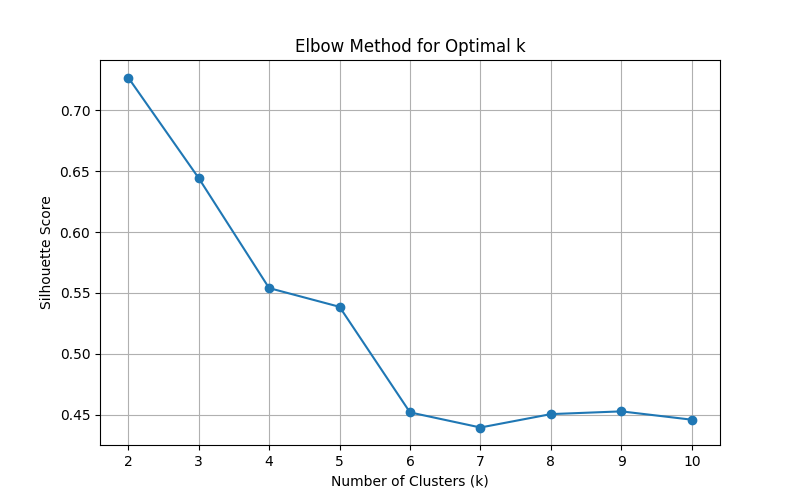

In [39]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

assembler = VectorAssembler(inputCols=selected_features, outputCol="model_features")
model_df = assembler.transform(scaled_df).select("CustomerID", "model_features")


# Step 2: Elbow Method
inertia = []
k_values = range(2, 11)  # Test k from 2 to 10

for k in k_values:
    kmeans = KMeans(featuresCol="model_features", k=k, seed=1)
    model = kmeans.fit(model_df)
    predictions = model.transform(model_df)
    evaluator = ClusteringEvaluator(featuresCol="model_features", metricName="silhouette")
    silhouette = evaluator.evaluate(predictions)
    inertia.append((k, silhouette))

# Plot the Elbow Method results
plt.figure(figsize=(8, 5))
plt.plot([i[0] for i in inertia], [i[1] for i in inertia], marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()
%matplot plt

#### 5.2 Finetuning the Parameters

In [40]:
# # Fine-Tune K-Means 
from pyspark.ml.evaluation import ClusteringEvaluator

# Fine-tune other parameters of KMeans with k=2
k = 2
kmeans = KMeans(featuresCol="model_features", k=k, seed=1)

# Set different values for maxIter and tol to fine-tune the model
max_iter_values = [10, 20, 50, 100]
tol_values = [1e-4, 1e-5, 1e-6]

best_model = None
best_silhouette = -1

for max_iter in max_iter_values:
    for tol in tol_values:
        kmeans.setMaxIter(max_iter)
        kmeans.setTol(tol)
        model = kmeans.fit(model_df)
        predictions = model.transform(model_df)
        evaluator = ClusteringEvaluator(featuresCol="model_features", metricName="silhouette")
        silhouette = evaluator.evaluate(predictions)
        
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_model = model

print(f"Best Silhouette Score: {best_silhouette}")
print(f"Best Parameters: maxIter={best_model.getMaxIter()}, tol={best_model.getTol()}")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-40:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 1693


Best Silhouette Score: 0.7271781404588696
Best Parameters: maxIter=10, tol=1e-06

#### 5.3 Attaching K_Means Cluster Result to combined_df

In [41]:
# Get the predictions from the best model
predictions = best_model.transform(model_df)

# Select the CustomerID and prediction columns, renaming prediction to "K_Means Clusters"
cluster_results = predictions.select("CustomerID", col("prediction").alias("KMeans_Clusters"))

# Join the cluster results with the combined_df
combined_df_with_clusters = combined_df.join(cluster_results, on="CustomerID", how="left")

# Show the resulting DataFrame with the new cluster column
combined_df_with_clusters.show(5)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---+------+-----------+-----------+--------+--------------+-------------+------------------+------------------+---------------------+------------------+-------------------+------------+------------------------+------------------+--------------------+--------------+---------------+
|          CustomerID|Age|Gender|   Location|  Education|  Income|MarriageStatus|LoyaltyStatus|total_transactions|       total_spent|avg_transaction_value|last_purchase_date|total_emails_opened|total_clicks|total_points_accumulated|total_pages_viewed|avg_session_duration|total_sessions|KMeans_Clusters|
+--------------------+---+------+-----------+-----------+--------+--------------+-------------+------------------+------------------+---------------------+------------------+-------------------+------------+------------------------+------------------+--------------------+--------------+---------------+
|4fdb8961-447c-433...| 38|  Male|    Phoenix|   Bachelor|51526.43|        Single|       

### 6. GMM Model Implemention and Fine Tuning 

#### 6.1 Determine the Optimal Number of Clusters Using Silhouette Score

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-42:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 3195


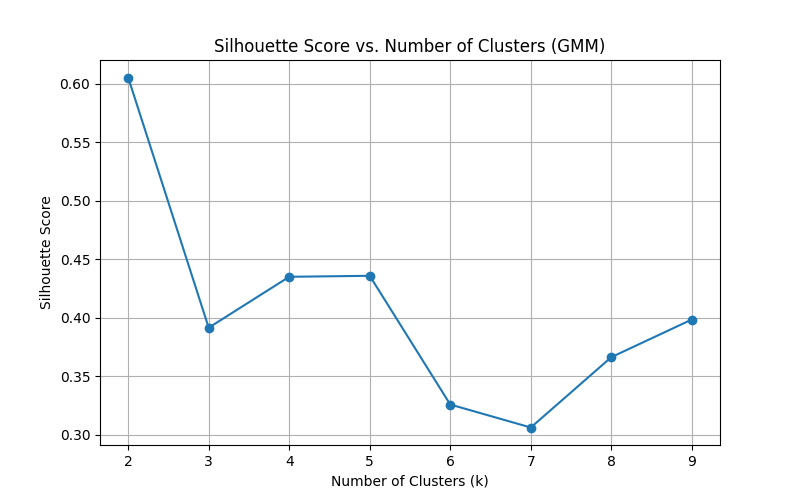

In [42]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Define the range for the number of clusters
k_range = range(2, 10)
silhouette_scores = []

for k in k_range:
    gmm = GaussianMixture(featuresCol="model_features", k=k, seed=1)
    gmm_model = gmm.fit(model_df)
    gmm_predictions = gmm_model.transform(model_df)
    
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator(featuresCol="model_features", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette = evaluator.evaluate(gmm_predictions)
    silhouette_scores.append(silhouette)
    print(f"Silhouette Score for k={k}: {silhouette:.4f}")

# Plot Silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(list(k_range), silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (GMM)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()
%matplot plt

#### 6.2 Fine-Tune the GMM Model with Detailed Parameters

In [43]:
# Define the optimal number of clusters based on Silhouette score
optimal_k = 2  # Replace with the k value that has the highest Silhouette score from the previous step

# Initialize the best GMM model
best_gmm_model = None
highest_silhouette = float("-inf")

# Fit the GMM model with the optimal number of clusters
gmm = GaussianMixture(featuresCol="model_features", k=optimal_k, seed=1)
gmm_model = gmm.fit(model_df)
gmm_predictions = gmm_model.transform(model_df)

# Evaluate the model
evaluator = ClusteringEvaluator(featuresCol="model_features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(gmm_predictions)


if silhouette > highest_silhouette:
    highest_silhouette = silhouette
    best_gmm_model = gmm_model

print(f"Silhouette Score for optimal k={optimal_k}: {silhouette:.4f}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-43:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 5295


Silhouette Score for optimal k=2: 0.6054

KMeans Model Silhouette is 0.7271781404588695 that is much better than GMM Silhouette score, therefore, we are going to use KMeans Model Cluster for our business evaluation.

As we choose KMenas, we are not going to attach the GMM cluster result into combined_df.

Though we have selected our better model, it is best practice to validate our model. So, Let's do Model Validation.

### 7. Model Validation: Checking Clustering Qaulity

In [49]:
scaled_df = scaled_df.join(combined_df_with_clusters, "CustomerID", "left")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- CustomerID: string (nullable = true)
 |-- scaled_Age: double (nullable = true)
 |-- scaled_Income: double (nullable = true)
 |-- scaled_total_transactions: double (nullable = true)
 |-- scaled_total_spent: double (nullable = true)
 |-- scaled_avg_transaction_value: double (nullable = true)
 |-- scaled_total_emails_opened: double (nullable = true)
 |-- scaled_total_clicks: double (nullable = true)
 |-- scaled_total_points_accumulated: double (nullable = true)
 |-- scaled_total_pages_viewed: double (nullable = true)
 |-- scaled_avg_session_duration: double (nullable = true)
 |-- scaled_total_sessions: double (nullable = true)
 |-- scaled_LoyaltyProgramStatus_encoded: double (nullable = true)
 |-- scaled_Education_encoded: double (nullable = true)
 |-- scaled_GenderIndex: double (nullable = true)
 |-- scaled_MarriageStatusIndex: double (nullable = true)
 |-- scaled_LocationIndex: double (nullable = true)
 |-- scaled_recency: double (nullable = true)
 |-- scaled_engagement_score:

In [51]:
# Import necessary libraries
import pandas as pd
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

validation_df = scaled_df.select(
    'scaled_total_spent',
    'scaled_avg_transaction_value',
    'scaled_total_points_accumulated',
    'scaled_LoyaltyProgramStatus_encoded',
    'scaled_engagement_score',
    'scaled_behavioral_score',
    'scaled_LTV',
    'KMeans_Clusters'
).dropDuplicates()

# Convert to Pandas DataFrame
validation_pd = validation_df.toPandas()

# Ensure 'KMeans_Clusters' column is unique
validation_pd = validation_pd.loc[:, ~validation_pd.columns.duplicated()]

# Extract features and labels
X = validation_pd[
    [
        'scaled_total_spent',
        'scaled_avg_transaction_value',
        'scaled_total_points_accumulated',
        'scaled_LoyaltyProgramStatus_encoded',
        'scaled_engagement_score',
        'scaled_behavioral_score',
        'scaled_LTV'
    ]
]
y = validation_pd['KMeans_Clusters']

# Compute Davies-Bouldin Score
db_score = davies_bouldin_score(X, y)
print(f"Davies-Bouldin Score: {db_score:.4f}")

# Compute Calinski-Harabasz Score
ch_score = calinski_harabasz_score(X, y)
print(f"Calinski-Harabasz Score: {ch_score:.4f}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Davies-Bouldin Score: 0.7171
Calinski-Harabasz Score: 16973.8232

combined_df_with_clusters.printSchema()

**Davies-Bouldin Index**

- The Davies-Bouldin Index measures the average similarity ratio of each cluster with its most similar cluster. Lower values indicate better clustering, as it means clusters are more distinct from each other.

- A score of 0.7171 suggests our clusters are well-defined and distinct. We can compare this with benchmarks or past results to see if improvement is possible. Overall, the current score is quite acceptable.

**Calinski-Harabasz Index**

- The Calinski-Harabasz Index, also known as the Variance Ratio Criterion, evaluates the ratio of the sum of between-cluster dispersion to within-cluster dispersion. Higher values indicate better-defined clusters.

- A score of 16973.8232 indicates that the clusters are well-defined and distinct from each other. Higher scores are better, so this suggests strong clustering performance.

**Overall Evaluation**

- The combination of a relatively low Davies-Bouldin Score and a high Calinski-Harabasz Score suggests that your KMeans clustering model is performing well. The clusters are both compact and well-separated, indicating a good fit for the data.

### 8. Customer Characteristics of each Cluster

#### 8.1 Characteristics of Numeric features

- **Cluster Size**

In [56]:
from pyspark.sql.functions import count

cluster_sizes = combined_df_with_clusters.groupBy('KMeans_Clusters').agg(count('*').alias('count'))

print("KMeans Cluster Sizes:")
cluster_sizes.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

KMeans Cluster Sizes:
+---------------+-----+
|KMeans_Clusters|count|
+---------------+-----+
|              1| 3694|
|              0| 6306|
+---------------+-----+

- **Difference between Main Features**

In [66]:
from pyspark.sql import functions as F

pd.set_option('display.max_columns', None)

# Calculate mean values for each cluster
cluster_profiles = combined_df_with_clusters.groupBy('KMeans_Clusters').agg(
    F.mean('Age').alias('mean_Age'),
    F.mean('Income').alias('mean_Income'),
    F.mean('total_spent').alias('mean_total_spent'),
    F.mean('avg_transaction_value').alias('mean_avg_transaction_value'),
    F.mean('total_transactions').alias('mean_total_transactions'),
    F.mean('total_emails_opened').alias('mean_total_emails_opened'),
    F.mean('total_clicks').alias('mean_total_clicks'),
    F.mean('total_pages_viewed').alias('mean_total_pages_viewed'),
    F.mean('avg_session_duration').alias('avg_session_duration'),
    F.mean('total_points_accumulated').alias('mean_total_points_accumulated')
)

# Convert to Pandas DataFrame
cluster_profiles_pd = cluster_profiles.toPandas()

# Create a comparison table for clusters 0 and 1
comparison_table = cluster_profiles_pd.loc[cluster_profiles_pd['KMeans_Clusters'].isin([0, 1])].set_index('KMeans_Clusters')

# Calculate percentage difference between cluster 1 and cluster 0
percentage_diff = ((comparison_table.loc[1] - comparison_table.loc[0]) / comparison_table.loc[0]).abs() * 100
comparison_table.loc['Percentage Difference'] = percentage_diff

print("Comparison Table between Cluster 0 and Cluster 1:")
print(comparison_table)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Comparison Table between Cluster 0 and Cluster 1:
                        mean_Age   mean_Income  mean_total_spent  \
KMeans_Clusters                                                    
1                      44.303194  63292.663086      25159.847204   
0                      44.167777  60372.694481      11907.434123   
Percentage Difference   0.306598      4.836572        111.295288   

                       mean_avg_transaction_value  mean_total_transactions  \
KMeans_Clusters                                                              
1                                      833.010459                30.301841   
0                                      400.217606                29.823184   
Percentage Difference                  108.139384                 1.604981   

                       mean_total_emails_opened  mean_total_clicks  \
KMeans_Clusters                                                      
1                                    875.828370         456.468868   
0       

- **Box Plots for Key Features**

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

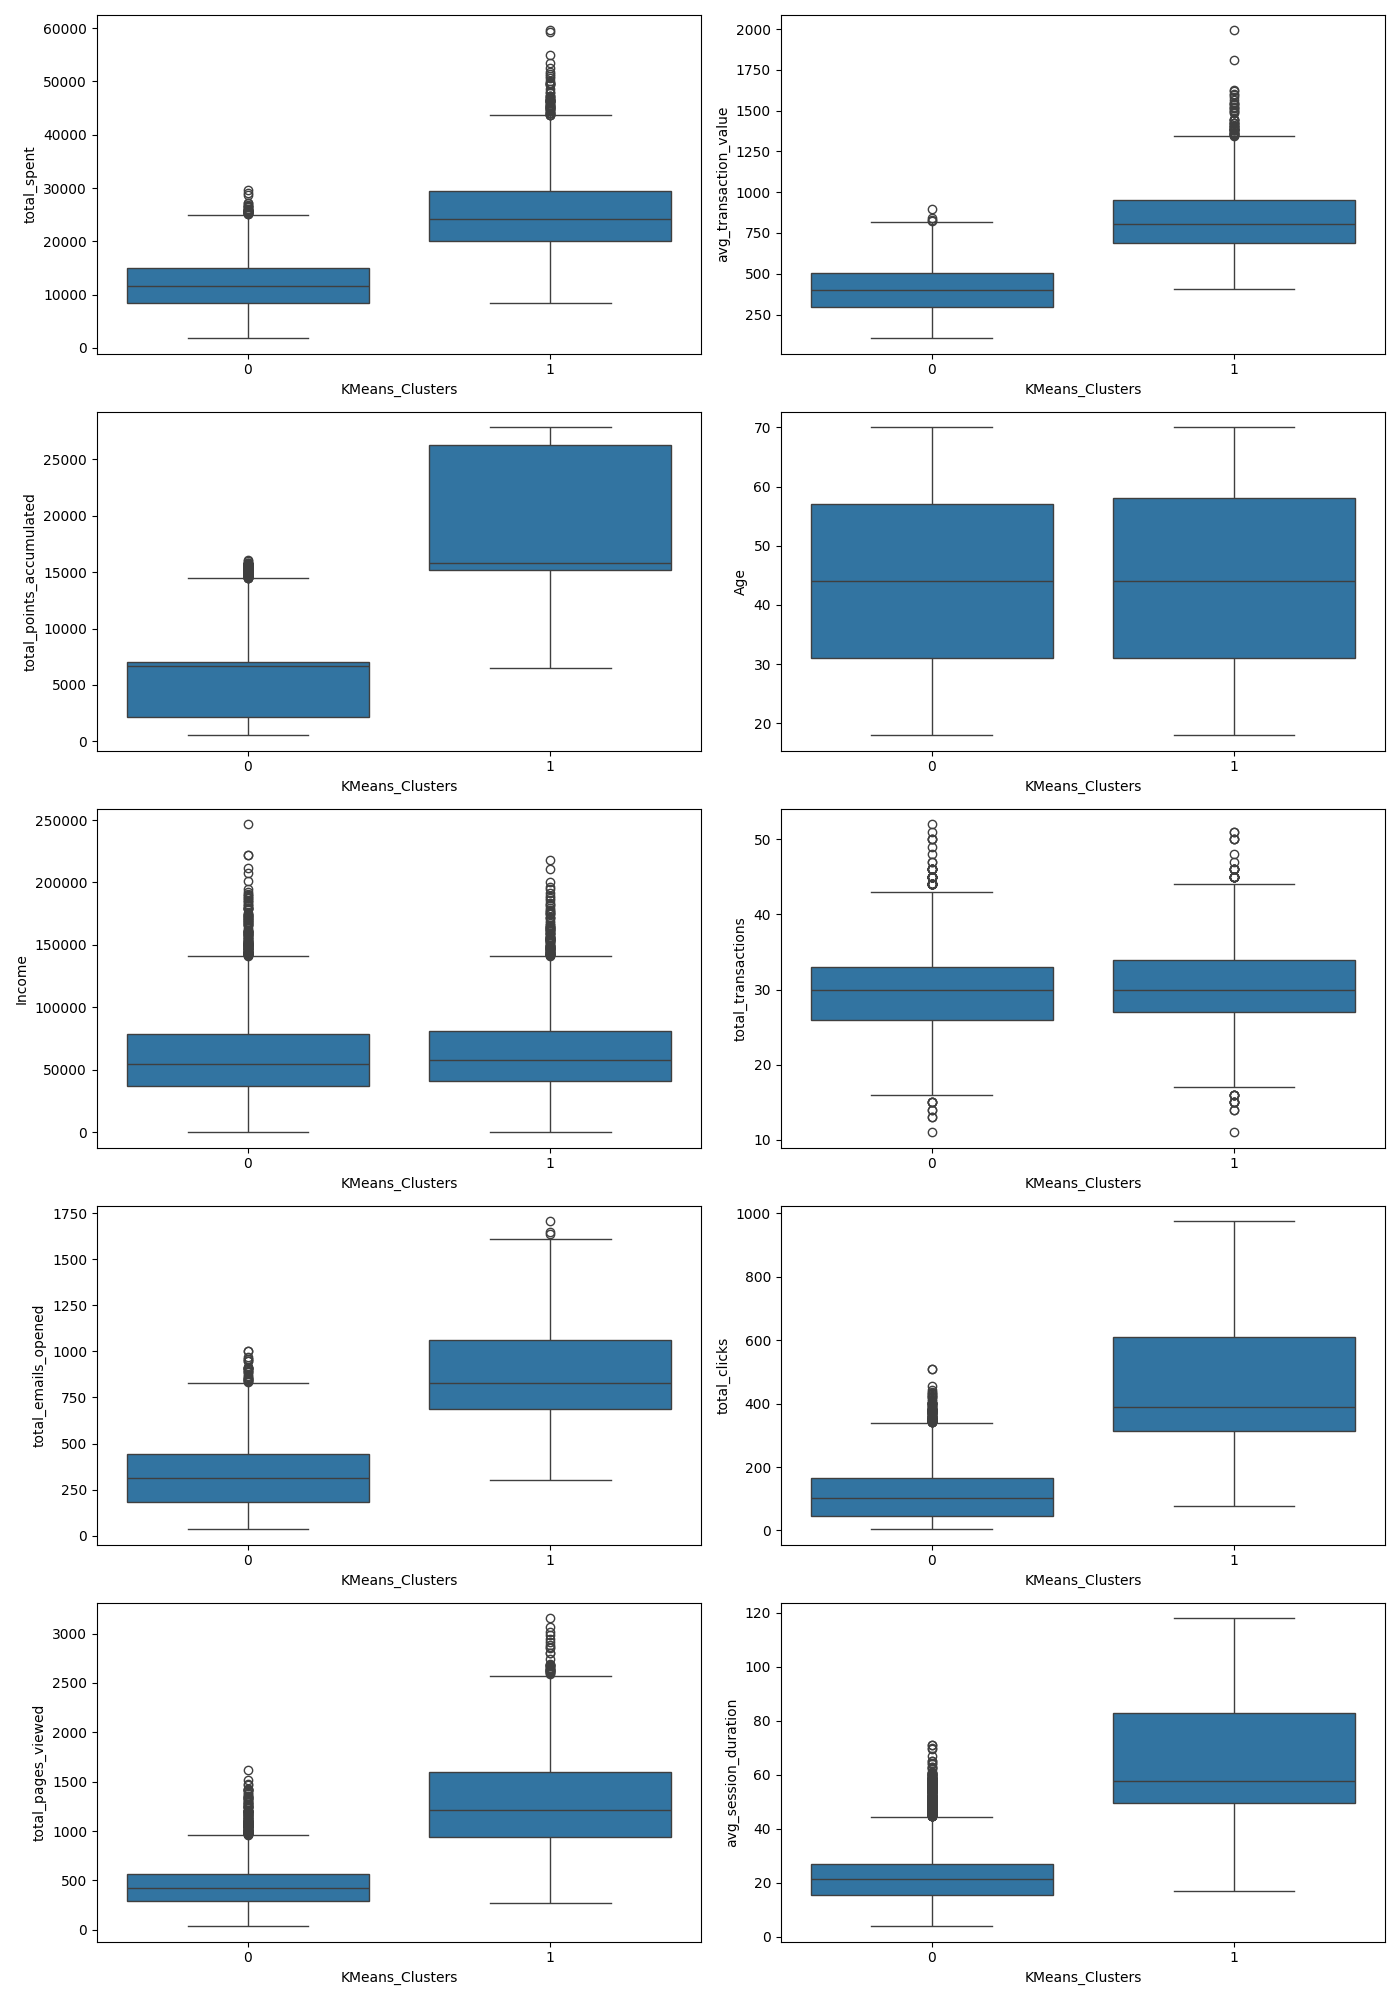

In [67]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Select relevant columns and convert to Pandas DataFrame
plot_data = combined_df_with_clusters.select(
    'KMeans_Clusters',
    'total_spent',
    'avg_transaction_value',
    'total_points_accumulated',
    'Age',
    'Income',
    'total_transactions',
    'total_emails_opened',
    'total_clicks',
    'total_pages_viewed',
    'avg_session_duration'
).toPandas()

# Create box plots
fig, axs = plt.subplots(5, 2, figsize=(14, 20))
sns.boxplot(x='KMeans_Clusters', y='total_spent', data=plot_data, ax=axs[0, 0])
sns.boxplot(x='KMeans_Clusters', y='avg_transaction_value', data=plot_data, ax=axs[0, 1])
sns.boxplot(x='KMeans_Clusters', y='total_points_accumulated', data=plot_data, ax=axs[1, 0])
sns.boxplot(x='KMeans_Clusters', y='Age', data=plot_data, ax=axs[1, 1])
sns.boxplot(x='KMeans_Clusters', y='Income', data=plot_data, ax=axs[2, 0])
sns.boxplot(x='KMeans_Clusters', y='total_transactions', data=plot_data, ax=axs[2, 1])
sns.boxplot(x='KMeans_Clusters', y='total_emails_opened', data=plot_data, ax=axs[3, 0])
sns.boxplot(x='KMeans_Clusters', y='total_clicks', data=plot_data, ax=axs[3, 1])
sns.boxplot(x='KMeans_Clusters', y='total_pages_viewed', data=plot_data, ax=axs[4, 0])
sns.boxplot(x='KMeans_Clusters', y='avg_session_duration', data=plot_data, ax=axs[4, 1])

plt.tight_layout()
plt.show()
%matplot plt

#### 8.2 Characteristics of Categorical features

- **Education**

In [68]:
from pyspark.sql import functions as F

# Calculate the count of each Education level within each KMeans_Cluster
education_counts = combined_df_with_clusters.groupBy('KMeans_Clusters', 'Education').count()

# Pivot the table to get a crosstab-like structure
cluster_demographics = education_counts.groupBy('KMeans_Clusters').pivot('Education').agg(F.first('count'))

# Normalize the counts by the total number of entries in each cluster
total_counts = education_counts.groupBy('KMeans_Clusters').agg(F.sum('count').alias('total'))
cluster_demographics = cluster_demographics.join(total_counts, on='KMeans_Clusters')
for col in cluster_demographics.columns:
    if col not in ['KMeans_Clusters', 'total']:
        cluster_demographics = cluster_demographics.withColumn(col, F.col(col) / F.col('total'))

# Drop the total column as it's no longer needed
cluster_demographics = cluster_demographics.drop('total')

# Show the result
print("Cluster Demographics (Education):")
cluster_demographics.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-68:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 5495


Cluster Demographics (Education):
+---------------+------------------+------------------+-------------------+--------------------+--------------------+
|KMeans_Clusters|          Bachelor|       High School|             Master|               Other|                 PhD|
+---------------+------------------+------------------+-------------------+--------------------+--------------------+
|              1|0.4095831077422848| 0.273957769355712|0.21115322144017326|0.053871142393069844|0.051434759068760154|
|              0|0.3985093561687282|0.3066920393276245| 0.1983824928639391| 0.05011100539169045| 0.04630510624801776|
+---------------+------------------+------------------+-------------------+--------------------+--------------------+

- **Loyalty Status**

In [69]:
from pyspark.sql import functions as F

# Calculate the count of each LoyaltyStatus within each KMeans_Cluster
loyalty_counts = combined_df_with_clusters.groupBy('KMeans_Clusters', 'LoyaltyStatus').count()

# Pivot the table to get a crosstab-like structure
cluster_demographics = loyalty_counts.groupBy('KMeans_Clusters').pivot('LoyaltyStatus').agg(F.first('count'))

# Normalize the counts by the total number of entries in each cluster
total_counts = loyalty_counts.groupBy('KMeans_Clusters').agg(F.sum('count').alias('total'))
cluster_demographics = cluster_demographics.join(total_counts, on='KMeans_Clusters')
for col in cluster_demographics.columns:
    if col not in ['KMeans_Clusters', 'total']:
        cluster_demographics = cluster_demographics.withColumn(col, F.col(col) / F.col('total'))

# Drop the total column as it's no longer needed
cluster_demographics = cluster_demographics.drop('total')

# Show the result
print("Cluster Demographics (LoyaltyStatus):")
cluster_demographics.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Cluster Demographics (LoyaltyStatus):
+---------------+--------------------+-------------------+-------------------+--------------------+
|KMeans_Clusters|               Basic|             Bronze|               Gold|              Silver|
+---------------+--------------------+-------------------+-------------------+--------------------+
|              1|2.707092582566324E-4|0.25717379534380075|0.20682187330806714|  0.5357336220898755|
|              0|   0.718046305106248|0.27656200444021567|               NULL|0.005391690453536315|
+---------------+--------------------+-------------------+-------------------+--------------------+

- **Preferred Categories**

In [70]:
from pyspark.sql import functions as F

# Join transactions_df with combined_df_with_clusters on 'CustomerID'
purchase_patterns = transactions_df.join(combined_df_with_clusters.select('CustomerID', 'KMeans_Clusters'), on='CustomerID')

# Calculate the count of each ProductCategory within each KMeans_Cluster
category_counts = purchase_patterns.groupBy('KMeans_Clusters', 'ProductCategory').count()

# Pivot the table to get a crosstab-like structure
preferred_categories = category_counts.groupBy('KMeans_Clusters').pivot('ProductCategory').agg(F.first('count'))

# Normalize the counts by the total number of entries in each cluster
total_counts = category_counts.groupBy('KMeans_Clusters').agg(F.sum('count').alias('total'))
preferred_categories_normalized = preferred_categories.join(total_counts, on='KMeans_Clusters')
for col in preferred_categories_normalized.columns:
    if col not in ['KMeans_Clusters', 'total']:
        preferred_categories_normalized = preferred_categories_normalized.withColumn(col, F.col(col) / F.col('total'))

# Drop the total column as it's no longer needed
preferred_categories_normalized = preferred_categories_normalized.drop('total')

# Show the result
print("Preferred Product Categories per Cluster:")
preferred_categories_normalized.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Preferred Product Categories per Cluster:
+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|KMeans_Clusters|              Books|           Clothing|        Electronics|     Home & Kitchen|             Sports|
+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|              1|0.19279045874838074|0.19850806271496851|0.20642337070621342|0.20058962790905435|0.20168847992138295|
|              0|0.20189827985005185| 0.2016430489458432|0.19788371041926994|0.19838353760667854| 0.2001914231781565|
+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+

### 9. Business Interpretation

#### 9.1 Cluster Profile

**Cluster 0: Upper Tier**

This cluster represents our upper-tier customers. They are slightly older and have marginally higher incomes, but these are not the defining factors.

Key Characteristics:

- Loyalty: Predominantly consists of loyal customers in higher loyalty tiers (Silver, Bronze, Gold).

- Engagement: Highly engaged, with higher spending, average transaction values, and total points accumulated.


**Cluster 1: Lower Tier**

This cluster is our lower-tier segment, comprising the majority of our customer base.

Key Characteristics:

- Loyalty: Primarily consists of Basic loyalty members, indicating low engagement and loyalty.

- Engagement: Lower spending, fewer transactions, and minimal engagement.


**Purchasing Pattern**

- There is no significant difference purchasing behavior between the two clusters.

#### 9.2 Recommendation

**For Upper Tier (Cluster 0)**

- **Value Loyalty**: Recognize and reward loyal customers with exclusive packages or plans to maintain their engagement and satisfaction.

- **Personalized Offers**: Provide tailored offers and experiences to enhance their shopping journey and encourage continued loyalty.

**For Lower Tier (Cluster 1)**

- **Engagement Campaigns**: Implement persuasive marketing campaigns to activate and engage this segment. Focus on promotions that encourage frequent purchases.

- **Loyalty Program Incentives**: Develop strategies to move these customers up the loyalty ladder. Offer incentives for increased engagement and spending.

- **Promotional Plans**: Design attractive promotional plans that appeal to this segment's needs and preferences, aiming to convert them into more loyal customers.

#### 9.4 Strategic Focus

- **Priority**: While valuing our loyal customers is crucial, the primary focus should be on activating and engaging the lower-tier segment, as they represent a significant portion of our customer base.

- **Goal**: Transform lower-tier customers into loyal, engaged customers through targeted strategies, ultimately increasing overall customer lifetime value and business growth.

### 10. Discussion of Limitations

- **Feature Selection Constraints:** While high correlation was used for feature selection, some potentially important features with lower correlation might have been excluded, possibly affecting the segmentation quality.

- **Model Assumptions:** KMeans assumes spherical clusters and may not perform well if the actual customer segments have different shapes or densities.

- **Temporal Dynamics:** The analysis is based on historical data, which may not account for dynamic changes in customer behavior over time.

******

***The Customer Segmentation Model has been successfully completed. The following appendix does not introduce new technologies or methods; instead, it focuses on analyzing high-risk customers.***

**********

### 11. Appendix: Exploring High-Risk Customers

In the above model, statistically, we found that segementing into 2 clusters is the optimal segementation, therefore, we do in-depth analysis based on 2 clusters.

As you may be aware of, the number of customers in lower-tier customers is much more than in the upper-tier. It means we have a lot ot lower-tier customers when we do segementation into two clusters.

Therefore, it would be better if we could explore the most risky customers from the lower-tier clusters.

Luckily, when we explore different clusters, we found that 3 cluster also provide an acceptable result though it is not as good as 2 clusters.

Let's re-explore on Silhouette score again.

#### 11.1 KMeans Implementation with 3 clusters

In [73]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Fine-tune K-Means with k=3
k = 3
kmeans_3 = KMeans(featuresCol="model_features", k=k, seed=1)

# Set different values for maxIter and tol to fine-tune the model
max_iter_values_3 = [10, 20, 50, 100]
tol_values_3 = [1e-4, 1e-5, 1e-6]

best_model_3 = None
best_silhouette_3 = -1

for max_iter in max_iter_values_3:
    for tol in tol_values_3:
        kmeans_3.setMaxIter(max_iter)
        kmeans_3.setTol(tol)
        model_3 = kmeans_3.fit(model_df)
        predictions_3 = model_3.transform(model_df)
        evaluator_3 = ClusteringEvaluator(featuresCol="model_features", metricName="silhouette")
        silhouette_3 = evaluator_3.evaluate(predictions_3)
        
        if silhouette_3 > best_silhouette_3:
            best_silhouette_3 = silhouette_3
            best_model_3 = model_3

print(f"Best Silhouette Score for 3 Clusters: {best_silhouette_3}")
print(f"Best Parameters for 3 Clusters: maxIter={best_model_3.getMaxIter()}, tol={best_model_3.getTol()}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-73:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 8498


Best Silhouette Score for 3 Clusters: 0.6444632083283584
Best Parameters for 3 Clusters: maxIter=20, tol=0.0001

In [75]:
from pyspark.sql.functions import col

# Get the predictions from the best model for 3 clusters
predictions = best_model_3.transform(model_df)

# Select the CustomerID and prediction columns, renaming prediction to "KMeans_3_Clusters"
cluster_results_3 = predictions.select("CustomerID", col("prediction").alias("KMeans_3_Clusters"))

# Join the cluster results with the combined_df
combined_df_with_clusters = combined_df.join(cluster_results_3, on="CustomerID", how="left")

# Show the resulting DataFrame with the new cluster column for 3 clusters
combined_df_with_clusters.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---+------+-----------+-----------+--------+--------------+-------------+------------------+------------------+---------------------+------------------+-------------------+------------+------------------------+------------------+--------------------+--------------+-----------------+
|          CustomerID|Age|Gender|   Location|  Education|  Income|MarriageStatus|LoyaltyStatus|total_transactions|       total_spent|avg_transaction_value|last_purchase_date|total_emails_opened|total_clicks|total_points_accumulated|total_pages_viewed|avg_session_duration|total_sessions|KMeans_3_Clusters|
+--------------------+---+------+-----------+-----------+--------+--------------+-------------+------------------+------------------+---------------------+------------------+-------------------+------------+------------------------+------------------+--------------------+--------------+-----------------+
|4fdb8961-447c-433...| 38|  Male|    Phoenix|   Bachelor|51526.43|        Single| 

#### 11.2 Numeric Characteristics of Clusters

- **Cluster Size**

In [76]:
from pyspark.sql.functions import count

cluster_sizes = combined_df_with_clusters.groupBy('KMeans_3_Clusters').agg(count('*').alias('count'))

print("KMeans Cluster Sizes:")
cluster_sizes.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

KMeans Cluster Sizes:
+-----------------+-----+
|KMeans_3_Clusters|count|
+-----------------+-----+
|                1| 1638|
|                2| 5331|
|                0| 3031|
+-----------------+-----+

- **Mean Values for Each Cluster**

In [77]:
from pyspark.sql import functions as F

# Set Pandas option to display all columns
pd.set_option('display.max_columns', None)

# Calculate mean values for each cluster
cluster_profiles_3 = combined_df_with_clusters_3.groupBy('KMeans_3_Clusters').agg(
    F.mean('Age').alias('mean_Age'),
    F.mean('Income').alias('mean_Income'),
    F.mean('total_spent').alias('mean_total_spent'),
    F.mean('avg_transaction_value').alias('mean_avg_transaction_value'),
    F.mean('total_transactions').alias('mean_total_transactions'),
    F.mean('total_emails_opened').alias('mean_total_emails_opened'),
    F.mean('total_clicks').alias('mean_total_clicks'),
    F.mean('total_pages_viewed').alias('mean_total_pages_viewed'),
    F.mean('avg_session_duration').alias('mean_avg_session_duration'),
    F.mean('total_points_accumulated').alias('mean_total_points_accumulated')
)

# Convert to Pandas DataFrame
cluster_profiles_3_pd = cluster_profiles_3.toPandas()

# Display the mean values for all clusters
print("Mean Values for Each Cluster:")
print(cluster_profiles_3_pd)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Mean Values for Each Cluster:
   KMeans_3_Clusters   mean_Age   mean_Income  mean_total_spent  \
0                  1  44.599512  64052.652167      29338.893162   
1                  2  44.247983  59451.597661      10792.021590   
2                  0  43.958430  63562.717737      20600.257690   

   mean_avg_transaction_value  mean_total_transactions  \
0                  968.769967                30.385836   
1                  366.863190                29.600075   
2                  679.089404                30.494886   

   mean_total_emails_opened  mean_total_clicks  mean_total_pages_viewed  \
0               1080.349817         618.627595              1652.048840   
1                282.937535          94.354718               401.557494   
2                648.672385         288.487298               904.334873   

   mean_avg_session_duration  mean_total_points_accumulated  
0                  82.620814                   25782.659951  
1                  20.140881               

- **Box Plots for Key Features**

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

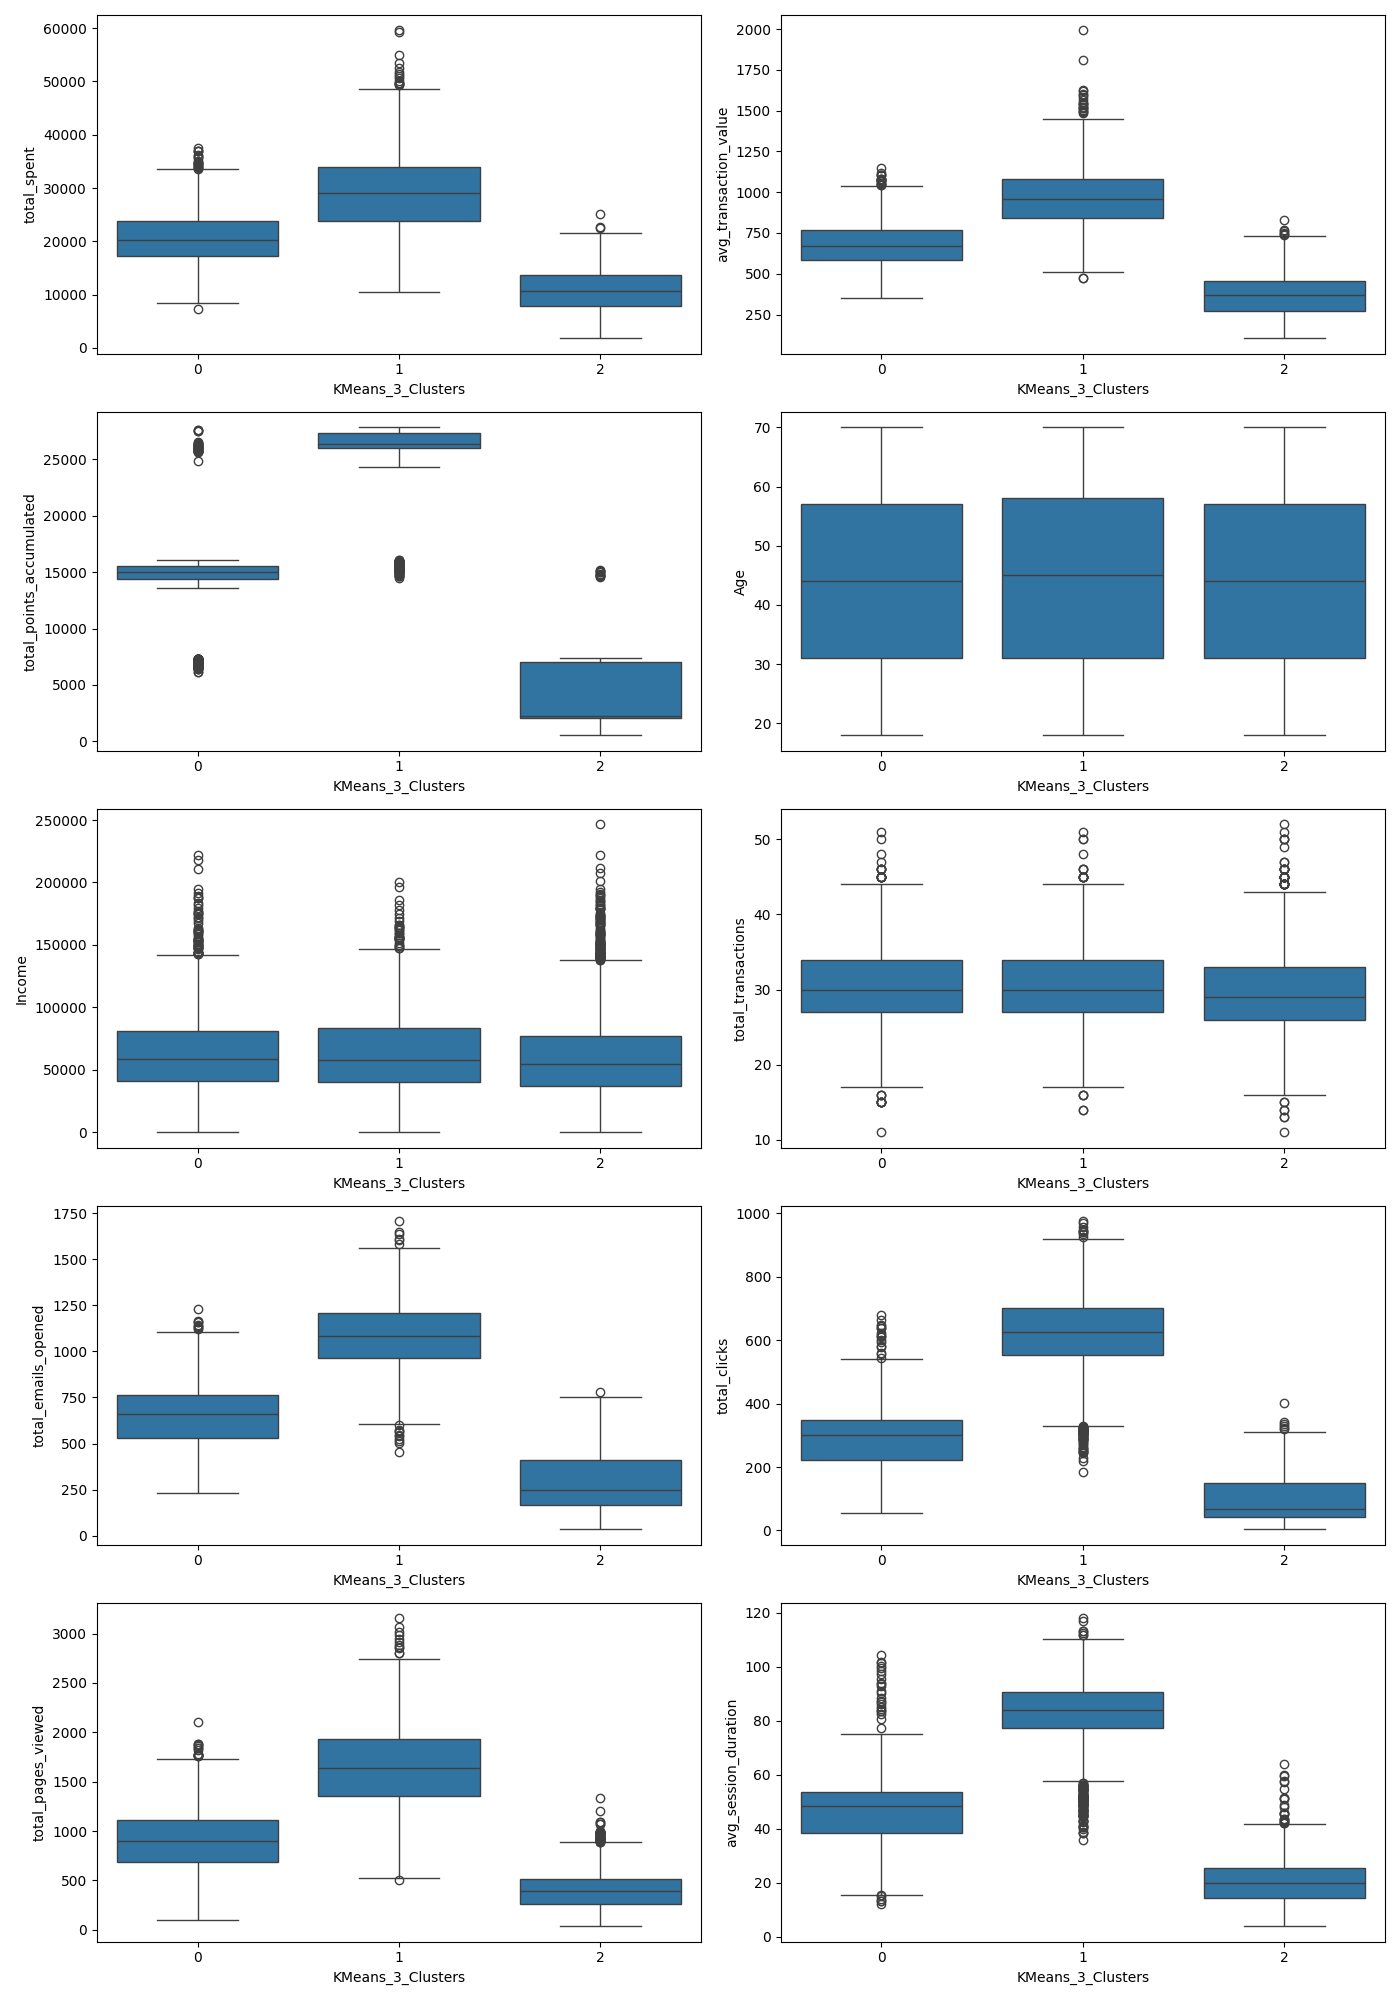

In [78]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Select relevant columns and convert to Pandas DataFrame for 3-cluster model
plot_data_3 = combined_df_with_clusters_3.select(
    'KMeans_3_Clusters',
    'total_spent',
    'avg_transaction_value',
    'total_points_accumulated',
    'Age',
    'Income',
    'total_transactions',
    'total_emails_opened',
    'total_clicks',
    'total_pages_viewed',
    'avg_session_duration'
).toPandas()

# Create box plots for 3-cluster model
fig, axs = plt.subplots(5, 2, figsize=(14, 20))
sns.boxplot(x='KMeans_3_Clusters', y='total_spent', data=plot_data_3, ax=axs[0, 0])
sns.boxplot(x='KMeans_3_Clusters', y='avg_transaction_value', data=plot_data_3, ax=axs[0, 1])
sns.boxplot(x='KMeans_3_Clusters', y='total_points_accumulated', data=plot_data_3, ax=axs[1, 0])
sns.boxplot(x='KMeans_3_Clusters', y='Age', data=plot_data_3, ax=axs[1, 1])
sns.boxplot(x='KMeans_3_Clusters', y='Income', data=plot_data_3, ax=axs[2, 0])
sns.boxplot(x='KMeans_3_Clusters', y='total_transactions', data=plot_data_3, ax=axs[2, 1])
sns.boxplot(x='KMeans_3_Clusters', y='total_emails_opened', data=plot_data_3, ax=axs[3, 0])
sns.boxplot(x='KMeans_3_Clusters', y='total_clicks', data=plot_data_3, ax=axs[3, 1])
sns.boxplot(x='KMeans_3_Clusters', y='total_pages_viewed', data=plot_data_3, ax=axs[4, 0])
sns.boxplot(x='KMeans_3_Clusters', y='avg_session_duration', data=plot_data_3, ax=axs[4, 1])

plt.tight_layout()
plt.show()
%matplot plt

#### 11.3 Characteristics of Categorical features

- **Education**

In [79]:
from pyspark.sql import functions as F

# Calculate the count of each Education level within each KMeans_3_Cluster
education_counts_3 = combined_df_with_clusters_3.groupBy('KMeans_3_Clusters', 'Education').count()

# Pivot the table to get a crosstab-like structure
cluster_demographics_3 = education_counts_3.groupBy('KMeans_3_Clusters').pivot('Education').agg(F.first('count'))

# Normalize the counts by the total number of entries in each cluster
total_counts_3 = education_counts_3.groupBy('KMeans_3_Clusters').agg(F.sum('count').alias('total'))
cluster_demographics_3 = cluster_demographics_3.join(total_counts_3, on='KMeans_3_Clusters')
for col in cluster_demographics_3.columns:
    if col not in ['KMeans_3_Clusters', 'total']:
        cluster_demographics_3 = cluster_demographics_3.withColumn(col, F.col(col) / F.col('total'))

# Drop the total column as it's no longer needed
cluster_demographics_3 = cluster_demographics_3.drop('total')

# Show the result
print("Cluster Demographics (Education) for 3 Clusters:")
cluster_demographics_3.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Cluster Demographics (Education) for 3 Clusters:
+-----------------+------------------+------------------+-------------------+-------------------+--------------------+
|KMeans_3_Clusters|          Bachelor|       High School|             Master|              Other|                 PhD|
+-----------------+------------------+------------------+-------------------+-------------------+--------------------+
|                1|0.3882783882783883|0.2783882783882784|0.21855921855921856|0.05372405372405373| 0.06105006105006105|
|                2|0.3991746389045207|0.3147627086850497|0.19395985743762897|0.05008441193021947| 0.04201838304258113|
|                0|0.4163642362256681|0.2678983833718245|0.21082151105245794|0.05278785879247773|0.052128010557571755|
+-----------------+------------------+------------------+-------------------+-------------------+--------------------+

- **Loyalty Status**

In [80]:
from pyspark.sql import functions as F

# Calculate the count of each LoyaltyStatus within each KMeans_3_Cluster
loyalty_counts_3 = combined_df_with_clusters_3.groupBy('KMeans_3_Clusters', 'LoyaltyStatus').count()

# Pivot the table to get a crosstab-like structure
cluster_demographics_3 = loyalty_counts_3.groupBy('KMeans_3_Clusters').pivot('LoyaltyStatus').agg(F.first('count'))

# Normalize the counts by the total number of entries in each cluster
total_counts_3 = loyalty_counts_3.groupBy('KMeans_3_Clusters').agg(F.sum('count').alias('total'))
cluster_demographics_3 = cluster_demographics_3.join(total_counts_3, on='KMeans_3_Clusters')
for col in cluster_demographics_3.columns:
    if col not in ['KMeans_3_Clusters', 'total']:
        cluster_demographics_3 = cluster_demographics_3.withColumn(col, F.col(col) / F.col('total'))

# Drop the total column as it's no longer needed
cluster_demographics_3 = cluster_demographics_3.drop('total')

# Show the result
print("Cluster Demographics (LoyaltyStatus) for 3 Clusters:")
cluster_demographics_3.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Cluster Demographics (LoyaltyStatus) for 3 Clusters:
+-----------------+--------------------+--------------------+--------------------+-------------------+
|KMeans_3_Clusters|               Basic|              Bronze|                Gold|             Silver|
+-----------------+--------------------+--------------------+--------------------+-------------------+
|                1|                NULL|0.007936507936507936|  0.4633699633699634| 0.5286935286935287|
|                2|  0.8291127368223598| 0.17088726317764022|                NULL|               NULL|
|                0|0.035961728802375456|  0.5839656878917849|0.001649620587264929|0.37842296271857473|
+-----------------+--------------------+--------------------+--------------------+-------------------+

- **Preferred Categories**

In [81]:
from pyspark.sql import functions as F

# Join transactions_df with combined_df_with_clusters_3 on 'CustomerID'
purchase_patterns_3 = transactions_df.join(combined_df_with_clusters_3.select('CustomerID', 'KMeans_3_Clusters'), on='CustomerID')

# Calculate the count of each ProductCategory within each KMeans_3_Cluster
category_counts_3 = purchase_patterns_3.groupBy('KMeans_3_Clusters', 'ProductCategory').count()

# Pivot the table to get a crosstab-like structure
preferred_categories_3 = category_counts_3.groupBy('KMeans_3_Clusters').pivot('ProductCategory').agg(F.first('count'))

# Normalize the counts by the total number of entries in each cluster
total_counts_3 = category_counts_3.groupBy('KMeans_3_Clusters').agg(F.sum('count').alias('total'))
preferred_categories_normalized_3 = preferred_categories_3.join(total_counts_3, on='KMeans_3_Clusters')
for col in preferred_categories_normalized_3.columns:
    if col not in ['KMeans_3_Clusters', 'total']:
        preferred_categories_normalized_3 = preferred_categories_normalized_3.withColumn(col, F.col(col) / F.col('total'))

# Drop the total column as it's no longer needed
preferred_categories_normalized_3 = preferred_categories_normalized_3.drop('total')

# Show the result
print("Preferred Product Categories per Cluster for 3 Clusters:")
preferred_categories_normalized_3.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-81:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 10296


Preferred Product Categories per Cluster for 3 Clusters:
+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|KMeans_3_Clusters|              Books|           Clothing|        Electronics|     Home & Kitchen|             Sports|
+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|                1|0.19062926946877762| 0.1969581290685526| 0.2085509925259182|0.20282488145945513|0.20103672747729648|
|                2| 0.2034626547864992|0.20299370080736132|0.19415962179495305|0.19907096414403225|0.20031305846715422|
|                0|0.19426593097479172|0.19806339932922212|0.20883912149734934| 0.1974899924267013|0.20134155577193552|
+-----------------+-------------------+-------------------+-------------------+-------------------+-------------------+

#### 11.4 Key Insights on Cluster 2: High-Risk Customers

1. **Proportion of Total Customers**
 
    Cluster 1 represents a substantial portion of the total customer base, indicating that over 50% of these customers could be considered at risk.

2. **Spending and Engagement**
 
    Customers within this cluster exhibit considerably lower spending and engagement scores, indicating limited interaction with the brand.
 
3. **Loyalty Status**
 
    The majority of these customers fall into the Basic loyalty tier, with a small number classified as Bronze.
 
4. **Age and Income**
 
    While there are no significant differences in age compared to other clusters, the income levels of these customers are slightly lower, though the difference is not substantial.
 
Additionally, other characteristics such as education and preferred product categories do not show notable variations when compared to other clusters.

#### 11.5 Business Strategy and Recommendations

1. **Re-engagement Initiatives**

    Launch targeted campaigns to re-engage these customers with personalized offers and discounts to encourage purchases.

2. **Loyalty Program Adjustments**

    Enhance loyalty programs to provide incentives for increased engagement and repeat purchases.

3. **Personalized Communication**

    Use personalized communication strategies to address their specific needs and preferences, fostering a stronger connection with the brand.

4. **Feedback Mechanisms**

    Implement feedback mechanisms to understand their disengagement reasons and adjust offerings accordingly.